# Daily Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import metrics
from sklearn.model_selection import train_test_split


plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


import warnings
warnings.filterwarnings('ignore')

In [2]:
#df = pd.read_csv('../capstone-data/daily-uni.csv')

In [3]:
df = pd.read_csv('../capstone-data/daily-merged.csv')

In [4]:
df.rename(columns={'Unnamed: 0':'date'},inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('d')

# Linear Model Setup

Testing lags for future modeling.

In [5]:
test = df[['total_rides']].copy()
test['test_lags'] = test['total_rides'].shift(31)
test.corr()

,total_rides,test_lags
total_rides,1.000000,0.087953
test_lags,0.087953,1.000000


In [6]:
rides = df[['total_rides']].copy()

In [7]:
rides['lag_1'] = rides['total_rides'].shift(1)
rides['lag_2'] = rides['total_rides'].shift(2)
rides['lag_3'] = rides['total_rides'].shift(3)
rides['lag_4'] = rides['total_rides'].shift(4)
rides['lag_5'] = rides['total_rides'].shift(5)
rides['lag_6'] = rides['total_rides'].shift(6)
rides['lag_7'] = rides['total_rides'].shift(7)
rides['lag_8'] = rides['total_rides'].shift(8)
rides['lag_364'] = rides['total_rides'].shift(364)

rides['time'] = range(0, rides.shape[0])

In [8]:
rides.corr()

,total_rides,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_364,time
total_rides,1.000000,0.576230,0.177608,0.124148,0.118786,0.162800,0.540037,0.897420,0.534499,0.840756,-0.256540
lag_1,0.576230,1.000000,0.576144,0.177346,0.123889,0.118532,0.162509,0.539932,0.897401,0.420641,-0.256344
lag_2,0.177608,0.576144,1.000000,0.576013,0.177078,0.123609,0.118186,0.162293,0.539835,0.011178,-0.256125
lag_3,0.124148,0.177346,0.576013,1.000000,0.575788,0.176651,0.123042,0.117823,0.162015,-0.042955,-0.255770
lag_4,0.118786,0.123889,0.177078,0.575788,1.000000,0.575589,0.176171,0.122714,0.117554,-0.045188,-0.255446
lag_5,0.162800,0.118532,0.123609,0.176651,0.575589,1.000000,0.575355,0.175870,0.122453,0.003737,-0.255131
lag_6,0.540037,0.162509,0.118186,0.123042,0.176171,0.575355,1.000000,0.575187,0.175575,0.403165,-0.254743
lag_7,0.897420,0.539932,0.162293,0.117823,0.122714,0.175870,0.575187,1.000000,0.575088,0.774284,-0.254491
lag_8,0.534499,0.897401,0.539835,0.162015,0.117554,0.122453,0.175575,0.575088,1.000000,0.394028,-0.254287
lag_364,0.840756,0.420641,0.011178,-0.042955,-0.045188,0.003737,0.403165,0.774284,0.394028,1.000000,-0.135915


In [9]:
#rides.to_csv('../capstone-data/daily-uni.csv')

In [10]:
rides.columns

Index(['total_rides', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_364', 'time'],
      dtype='object')

## Linear TimeSeries Model

In [11]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_4','lag_2',}),
                                                 rides['total_rides'],
                                                 test_size=.2,
                                                 shuffle=False)

In [12]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_3,lag_5,lag_6,lag_7,lag_8,lag_364,time
date,,,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-02,1.0,423647.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2001-01-03,1.0,1282779.0,NaN,NaN,NaN,NaN,NaN,NaN,2
2001-01-04,1.0,1361355.0,423647.0,NaN,NaN,NaN,NaN,NaN,3
2001-01-05,1.0,1420032.0,1282779.0,NaN,NaN,NaN,NaN,NaN,4


In [13]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     6190.
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        02:55:38   Log-Likelihood:                -75635.
No. Observations:                5747   AIC:                         1.513e+05
Df Residuals:                    5738   BIC:                         1.513e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.918e+04   1.73e+04     -1.112      0.266    -5.3e+04    1.46e+04
lag_1          0.1656      0.009     19.185      0.000       0.149       0.183
lag_3          0.0123      0.005      2.523      0.012       0.003       0.022
lag_5         -0.0015      0.005     -0.276      0.783      -0.012       0.009
lag_6          0.0245      0.006      4.255      0.000       0.013       0.036
lag_7          0.2627      0.009     30.242      0.000       0.246       0.280
lag_8         -0.1225      0.009    -13.946      0.000      -0.140      -0.105
lag_364        0.6871      0.008     82.626      0.000       0.671       0.703
time          -6.1503      1.035     -5.944      0.000      -8.179      -4.122
==============================================================================
Omnibus:                     2119.652   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80673.705
Skew:                          -1.077   Prob(JB):                         0.00
Kurtosis:                      21.228   Cond. No.                     3.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.5993377758806566

In [15]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

317766.5220055624

Initial and basic testing shows we are off by around 317,000 riders per day with an AIC of 151,300.

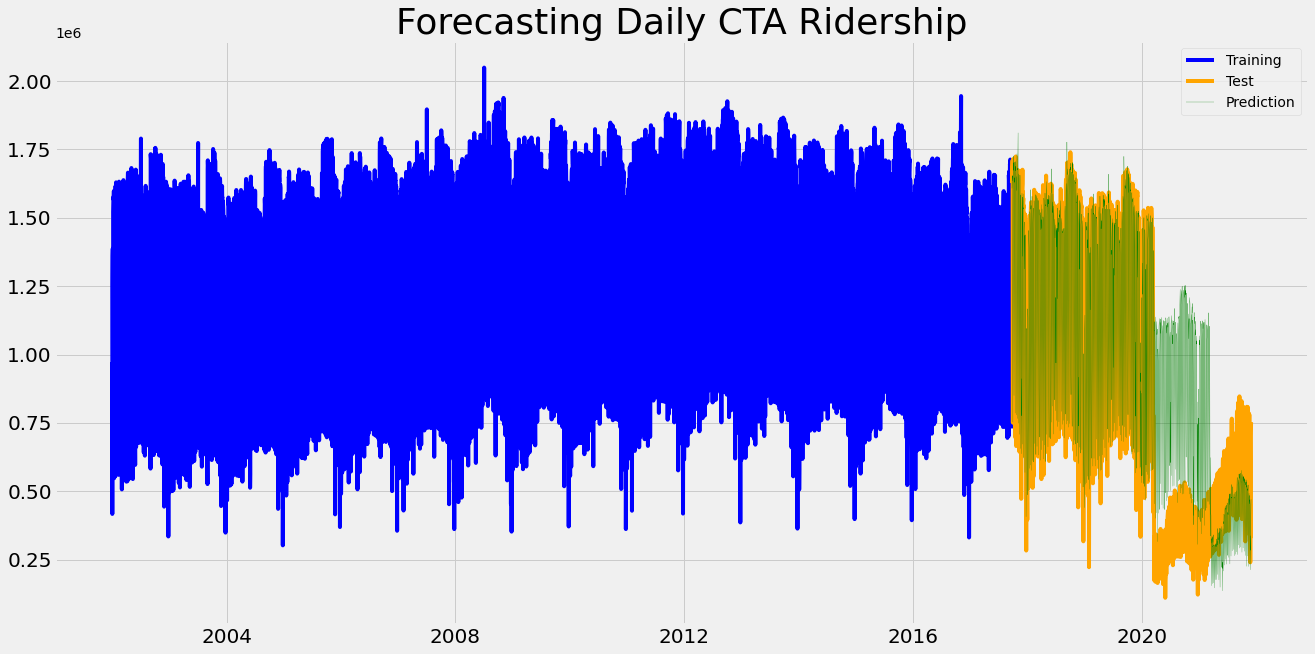

In [16]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction',linewidth=.25)
# Set label.
plt.title(label = 'Forecasting Daily CTA Ridership', fontsize=36)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.legend();

Does a decent job of handling the data until the covid drop off, not very effecitve with sudden shocks.

In [18]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_4','lag_2','lag_364'}),
                                                 rides['total_rides'],
                                                 test_size=.2,
                                                 shuffle=False)

In [19]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_3,lag_5,lag_6,lag_7,lag_8,time
date,,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-02,1.0,423647.0,NaN,NaN,NaN,NaN,NaN,1
2001-01-03,1.0,1282779.0,NaN,NaN,NaN,NaN,NaN,2
2001-01-04,1.0,1361355.0,423647.0,NaN,NaN,NaN,NaN,3
2001-01-05,1.0,1420032.0,1282779.0,NaN,NaN,NaN,NaN,4


In [20]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     2968.
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        02:57:42   Log-Likelihood:                -82716.
No. Observations:                6103   AIC:                         1.654e+05
Df Residuals:                    6095   BIC:                         1.655e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.796e+05   2.46e+04     11.390      0.000    2.32e+05    3.28e+05
lag_1          0.3474      0.012     29.035      0.000       0.324       0.371
lag_3         -0.0459      0.007     -6.568      0.000      -0.060      -0.032
lag_5         -0.0758      0.007    -10.147      0.000      -0.090      -0.061
lag_6          0.0582      0.008      7.063      0.000       0.042       0.074
lag_7          0.8028      0.008     97.866      0.000       0.787       0.819
lag_8         -0.2975      0.012    -24.335      0.000      -0.321      -0.274
time           3.8762      1.395      2.778      0.005       1.141       6.612
==============================================================================
Omnibus:                     1233.460   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40697.097
Skew:                          -0.135   Prob(JB):                         0.00
Kurtosis:                      15.648   Cond. No.                     3.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.8287545747605424

In [22]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

207743.97202212195

Initial and basic testing shows we are off by around 317,000 riders per day with an AIC of 151,300.

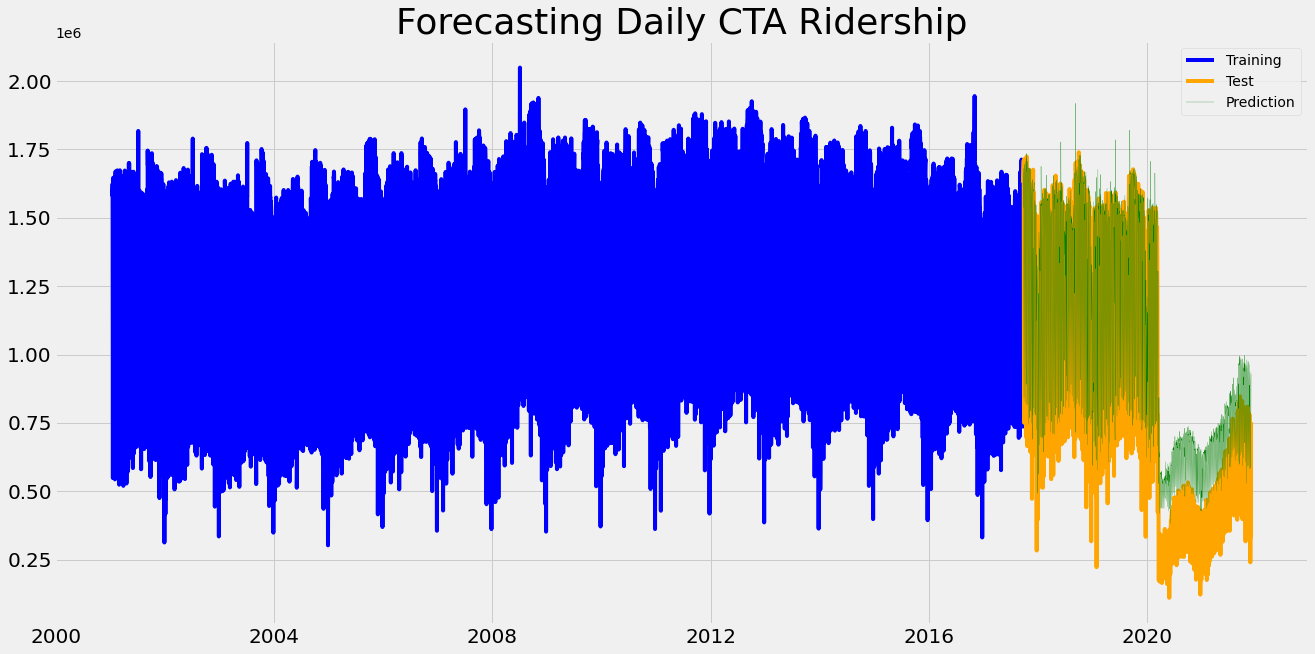

In [23]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction',linewidth=.25)
# Set label.
plt.title(label = 'Forecasting Daily CTA Ridership', fontsize=36)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.legend();

Removing the yearly lag seems to make the RMSE and AIC worse, but it handles the shock more elegantly.

## ARIMA

#### Finding '*d*'

In [24]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [25]:
rides['rides_first_diff'] = rides['total_rides'].diff(1)
rides['rides_second_diff'] = rides['total_rides'].diff(1).diff(1)

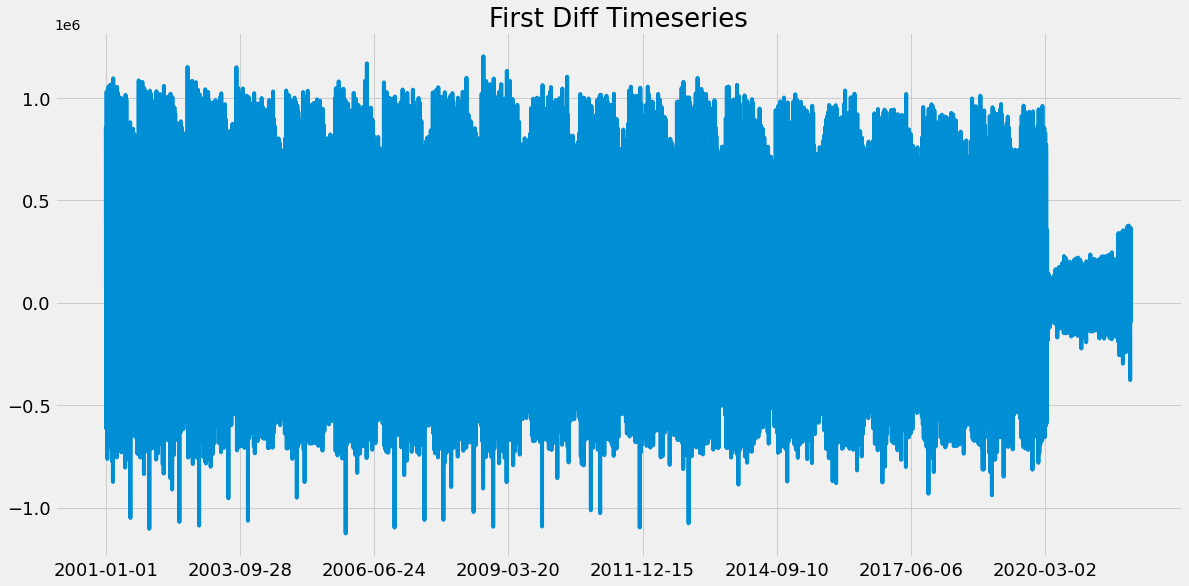

In [26]:
plot_series(rides,['rides_first_diff'], title = 'First Diff Timeseries', steps=1000)

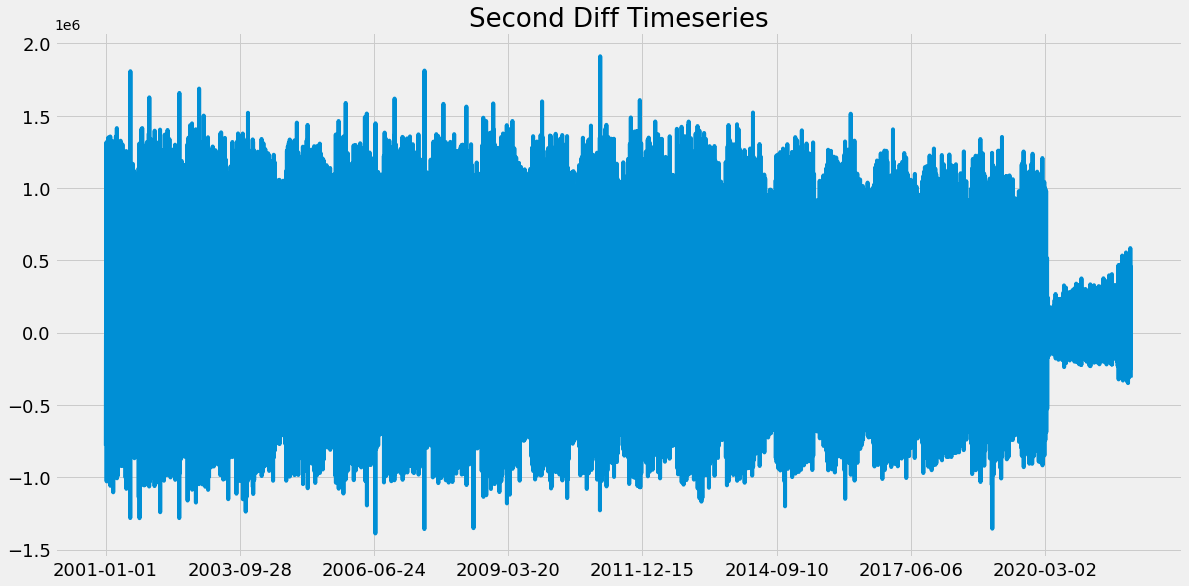

In [27]:
plot_series(rides,['rides_second_diff'], title = 'Second Diff Timeseries', steps=1000)

In [28]:
# Code written by Joseph Nelson
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index = ['Test Statsitic','p-value'])
    return dfoutput

In [29]:
print(f'Orig: \n{interpret_dftest(adfuller(rides["total_rides"]))}\n\nFirst Diff: \n{interpret_dftest(adfuller(rides["rides_first_diff"].dropna()))}')



Orig: 
Test Statsitic   -2.566741
p-value           0.100068
dtype: float64

First Diff: 
Test Statsitic   -20.419752
p-value            0.000000
dtype: float64


Since in the original data the p-value is not less than 0.05 we cannot reject Null Hypothesis; however, our first order difference is low enough to continue with '*d = 1*.'

#### Finding '*p*' & '*q*'

In [30]:
y_train, y_test = train_test_split(rides['rides_first_diff'], test_size=.2,shuffle=False)

In [73]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(14):
    for q in range(14):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order = (p, 1, q)) 
            
            model = arima.fit()

            if model.aic < best_aic:
                
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('Model Completed.')
print(f'Best ARIMA: ({best_p},1,{best_q}).')
print(f'AIC: {best_aic}.')



Model Completed.
Best ARIMA: (9,1,12).
AIC: 163297.6246061683.


In [74]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), 
             order = (9,1,12)) # Endog = Y variable 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = arima.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])


In [90]:
print(f'AIC: {arima.aic}, RMSE: {metrics.mean_squared_error(y_test,preds,squared=False)}, STD: {rides["total_rides"].std()}')

AIC: 163297.6246061683, RMSE: 182640.854064721, STD: 452648.37201676704


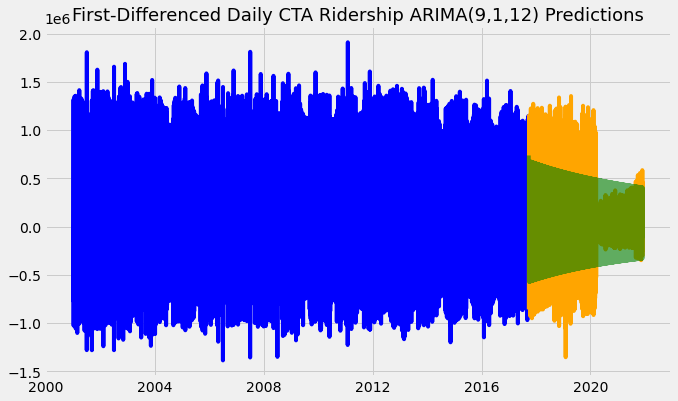

In [78]:
plt.figure(figsize=(10,6))
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'b')
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')
plt.plot(y_test.index,preds,color = 'g',alpha=.60)

plt.title(label = 'First-Differenced Daily CTA Ridership ARIMA(9,1,12) Predictions',fontsize=18)
plt.show();

The full ARIMA model seems to adjust well to sudden shocks but the predictions aren't that accurate.

In [138]:
y_train.index.duplicated().sum()

0

### SARIMAX

In [147]:
model = SARIMAX(y_train.astype(float).dropna(), order = (2,1,2), seasonal_order=(2,1,2,7))
sari = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35305D+01    |proj g|=  1.15409D-01

At iterate    5    f=  1.34712D+01    |proj g|=  2.43326D-02

At iterate   10    f=  1.34627D+01    |proj g|=  9.76082D-03

At iterate   15    f=  1.34475D+01    |proj g|=  3.51432D-03

At iterate   20    f=  1.34451D+01    |proj g|=  1.72282D-02

At iterate   25    f=  1.34444D+01    |proj g|=  3.18803D-03

At iterate   30    f=  1.34444D+01    |proj g|=  3.04434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [161]:
preds_train = sari.predict(start = y_train.index[1], end = y_train.index[-1])
preds = sari.predict(start = y_test.index[0], end = y_test.index[-1])

metrics.mean_squared_error(y_train.dropna(),preds_train, squared=False), metrics.mean_squared_error(y_test,preds,squared=False)

(152035.95795066832, 238196.33740542503)

In [183]:
arima.aic, sari.aic

(163297.6246061683, 164308.8533178185)

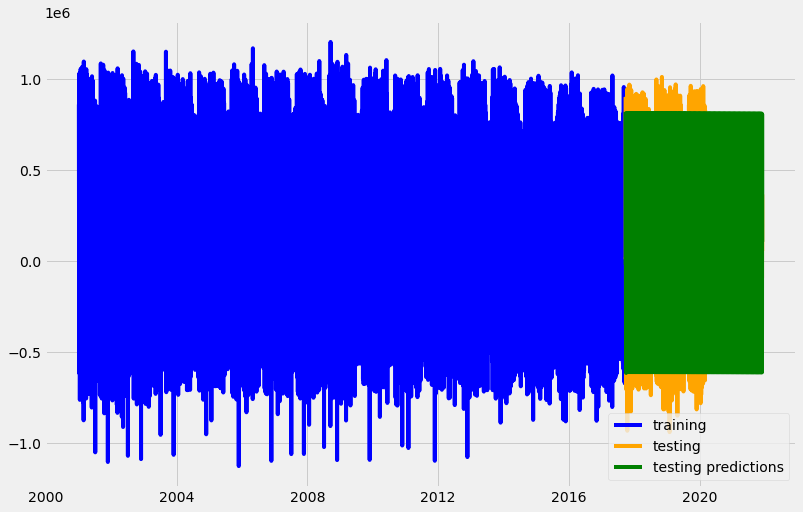

In [181]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')

plt.plot(y_test, color = 'orange', label = 'testing')

plt.plot(preds, color = 'green', label ='testing predictions')
plt.legend();


In [31]:
import itertools